In [1]:
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics.pairwise import rbf_kernel
from ISVDD.ISVDD import ISVDD
from sklearn.svm import OneClassSVM

In [2]:
features, labels = fetch_kddcup99(return_X_y=True, as_frame=True, percent10=True)
sample_indices = features.sample(10000).index
features = features.loc[sample_indices]
labels = labels.loc[sample_indices]

In [3]:
basic_features = ["duration", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent"]
content_features = ["hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell",
                    "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files",
                    "num_outbound_cmds", "is_host_login", "is_guest_login"]
traffic_features = ["count", "serror_rate", "rerror_rate", "same_srv_rate", "diff_srv_rate",
                    "srv_count", "srv_serror_rate", "srv_rerror_rate", "srv_diff_host_rate"]


In [35]:
ordinary_features = features[basic_features].astype(float)
ordinary_features = (ordinary_features - ordinary_features.mean()) / (ordinary_features.std() + 1e-5)
privileged_features = features[traffic_features + content_features].astype(float)
privileged_features = (privileged_features - privileged_features.mean()) / (privileged_features.std() + 1e-5)
labels = labels

In [37]:
def evaluate_parameters(model, ordinary_features,
                        labels, privilged_features=None):
    splitter = KFold(n_splits=10)
    all_scores = []
    for test, train in splitter.split(labels):
        train_labels = labels.iloc[train]
        normal_data_indices = train_labels[train_labels == b"normal."].index
        train_oridnary_features = ordinary_features.loc[normal_data_indices]
        if privilged_features is not None:
            train_privileged_features = privilged_features.loc[normal_data_indices]
            model.fit(train_oridnary_features, train_privileged_features)
        else:
            model.fit(train_oridnary_features)
        test_features = ordinary_features.iloc[test]
        predictions = model.decision_function(test_features)
        test_labels = labels.iloc[test] != b"normal."
        all_scores.append(average_precision_score(test_labels, -predictions))
    return np.mean(all_scores), np.std(all_scores)

In [38]:
model = OneClassSVM()

In [52]:
all_gammas = np.logspace(-7, 7, 30)

In [53]:
ordinary_average_precision_mean = np.zeros_like(all_gammas)
ordinary_average_precision_std = np.zeros_like(all_gammas)

for index, gamma in enumerate(all_gammas):
    average_precision, average_precision_std = evaluate_parameters(OneClassSVM(gamma=gamma), ordinary_features, labels)
    ordinary_average_precision_mean[index] = average_precision
    ordinary_average_precision_std[index] = average_precision_std

In [54]:
privileged_average_precision_mean = np.zeros_like(all_gammas)
privileged_average_precision_std = np.zeros_like(all_gammas)

for index, gamma in enumerate(all_gammas):
    priv_kernel = partial(rbf_kernel, gamma=1e-4)
    kernel = partial(rbf_kernel, gamma=gamma)
    model = ISVDD(0.1, kernel, priv_kernel, privileged_regularization=0.1, tol=0.0001, max_iter=100, silent=True)
    average_precision, average_precision_std = evaluate_parameters(model, ordinary_features, labels, privileged_features)
    privileged_average_precision_mean[index] = average_precision
    privileged_average_precision_std[index] = average_precision_std

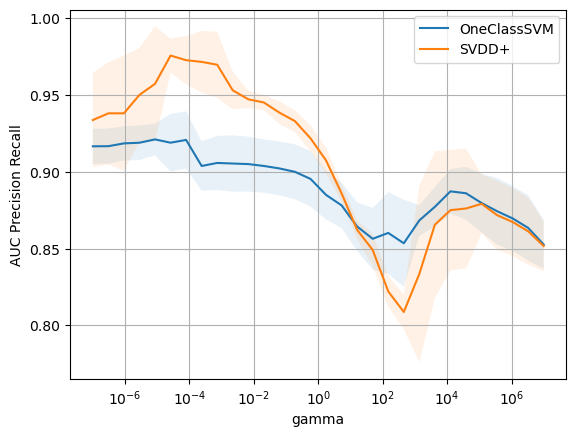

In [56]:
plt.plot(all_gammas, ordinary_average_precision_mean, label="OneClassSVM")
plt.fill_between(all_gammas, ordinary_average_precision_mean-ordinary_average_precision_std, 
                 ordinary_average_precision_mean+ordinary_average_precision_std, alpha=0.1)

plt.plot(all_gammas, privileged_average_precision_mean, label="SVDD+")
plt.fill_between(all_gammas, privileged_average_precision_mean-privileged_average_precision_std, 
                 privileged_average_precision_mean+privileged_average_precision_std, alpha=0.1)

plt.xscale("log")
plt.xlabel("gamma")
plt.ylabel("AUC Precision Recall")
plt.legend(loc="best")
plt.grid(True)